### Starbucks Capstone Challenge
# Linear Classifier

This notebook aims to train a feed-forward neural network to classify offer sending as appropriate or not. Being a traditional classification approach, this model will be the benchmark model to compare other classification methods.

## Define functions to train the classifier

### Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from models import LinearNN

### Load the datasets

In [2]:
!unzip -o dataloaders.zip
train_dataloader, valid_dataloader, test_dataloader = \
    torch.load('dataloaders.pt')

Archive:  dataloaders.zip
  inflating: dataloaders.pt          


### Define validation and training loops

In [3]:
def validate(model, dataloader=valid_dataloader, verbose=False):
    with torch.no_grad():
        model.eval()
        POS, NEG = 0, 0
        TP, TN, FP, FN = 0, 0, 0, 0
        valid_loss = 0
        for features, targets in dataloader:
            targets = targets.view(-1)
            positive = targets == 1
            negative = ~positive

            prediction = model(features)
            targets = targets.view(-1,1).to(dtype=torch.float)
            valid_loss += criterion(prediction, targets)

            prediction = torch.sigmoid(prediction)
            prediction = prediction.round()

            ## Compare prediction with target POSITIVE
            POS += positive.sum()
            # Target TRUE, Prediction TRUE --> True Positive
            TP += targets[positive].eq(prediction[positive]).sum()

            ## Compare prediction with target NEGATIVE
            NEG += negative.sum()
            # Target FALSE, Prediction FALSE --> True Negative
            TN += targets[negative].eq(prediction[negative]).sum()

        FN += POS - TP # Target TRUE, Prediction FALSE --> False Negative
        FP += NEG - TN # Target FALSE, Prediction TRUE --> False Positive

        # normalize the loss
        valid_loss /= len(dataloader)

        if verbose:
            print(f'\n\tValidation ... loss: {valid_loss:7.4f}')
            print(f'\t\tTP: {TP:4d}\tFP: {FP:4d}\tOP: {TP+FP:4d}')
            print(f'\t\tFN: {FN:4d}\tTN: {TN:4d}\tON: {TN+FN:4d}')
            print(f'\t\tCP: {POS:4d}\tCN: {NEG:4d}')
            print('\tAccuracy: {:5.2f}%\tPrecision: {:5.2f}\tRecall: {:5.2f}\n'
                  .format((TP+TN)/float(POS+NEG)*100,
                          TP/float(TP+FP), TP/float(TP+FN)))

        model.train()
        return valid_loss

In [4]:
def train(model, dataloader=train_dataloader, epochs=5000):
    train_loss = []
    valid_loss = []

    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, targets) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            targets = targets.view(-1,1).to(dtype=torch.float)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        lr_scheduler.step(train_loss[-1])

        if epoch % 10 == 0:
            print('Epoch {:4d}\ttrain loss: {:7.4f}\t' \
                  .format(epoch, train_loss[-1]))
            loss = validate(model, verbose=True)
            valid_loss.append(loss)
        else:
            loss = validate(model, verbose=False)
            valid_loss.append(loss)
            print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalid loss: {:7.4f}' \
                  .format(epoch, train_loss[-1], valid_loss[-1]))

    return train_loss, valid_loss

## Build and train the Linear Classifier

In [5]:
linear_classifier = LinearNN(input_size=16, output_size=1,
                             hidden_layers=[128,128,128])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(linear_classifier.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=100, verbose=True)

In [6]:
linear_loss = train(linear_classifier, epochs=100)

Epoch    1	train loss:  0.6502	valid loss:  0.6140
Epoch    2	train loss:  0.6131	valid loss:  0.6031
Epoch    3	train loss:  0.6071	valid loss:  0.5991
Epoch    4	train loss:  0.6037	valid loss:  0.5977
Epoch    5	train loss:  0.6010	valid loss:  0.5988
Epoch    6	train loss:  0.5988	valid loss:  0.5951
Epoch    7	train loss:  0.5991	valid loss:  0.5944
Epoch    8	train loss:  0.5976	valid loss:  0.5937
Epoch    9	train loss:  0.5953	valid loss:  0.5936
Epoch   10	train loss:  0.5956	

	Validation ... loss:  0.5931
		TP: 2852	FP: 1701	OP: 4553
		FN: 1433	TN: 3554	ON: 4987
		CP: 4285	CN: 5255
	Accuracy: 67.15%	Precision:  0.63	Recall:  0.67

Epoch   11	train loss:  0.5945	valid loss:  0.5929
Epoch   12	train loss:  0.5936	valid loss:  0.5914
Epoch   13	train loss:  0.5935	valid loss:  0.5921
Epoch   14	train loss:  0.5930	valid loss:  0.5909
Epoch   15	train loss:  0.5921	valid loss:  0.5904
Epoch   16	train loss:  0.5921	valid loss:  0.5899
Epoch   17	train loss:  0.5918	valid loss:  

## Plot results

### Training phase

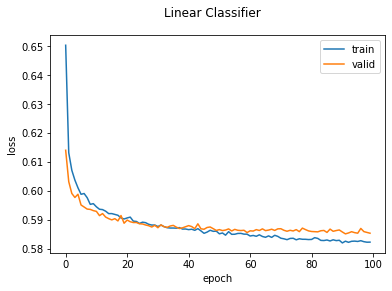

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Linear Classifier')
ax.plot(linear_loss[0], label='train')
ax.plot(linear_loss[1], label='valid')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend()

plt.show()

### Test the trained model

In [8]:
loss = validate(linear_classifier, test_dataloader, verbose=True)


	Validation ... loss:  0.5772
		TP: 2984	FP: 1638	OP: 4622
		FN: 1303	TN: 3609	ON: 4912
		CP: 4287	CN: 5247
	Accuracy: 69.15%	Precision:  0.65	Recall:  0.70

